In [1]:
#importing dependencies
import numpy as np
import os
import pickle as pkl
import math
from math import log2
import utils
from collections import Counter, defaultdict
import copy
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [2]:
base_dir_name = os.getcwd()
data_dir_name = "project_data"
data_dir = os.path.join(base_dir_name, data_dir_name)

### Analyzing data

In [3]:
def load_data(signal_filename, relevance_filename, vocab_dict, vocab_id_list, vocab_frequency):
    
    # We will return these 7 things!
    query_dict = {} #maps queries to query id (Assuming distinct queries)
    doc_dict = {}  #maps docs to doc id
    query_doc_dict = {} #maps query ids to list of doc ids
    query_id_list = [] #list
    doc_id_list = []
    query_doc_relevance = {}
    docId_to_content = {} #dict maps from doc id to the contents in the doc. The content is saved as a list of vocab_ids
    results_dict = {
        'query_dict': query_dict,
        'doc_dict': doc_dict,
        'query_doc_dict': query_doc_dict,
        'query_id_list': query_id_list,
        'doc_id_list': doc_id_list,
        'query_doc_relevance': query_doc_relevance,
        'docId_to_content': docId_to_content,
    }
    
    doc_list_for_query = []
    query_repetitions = {} #dict mapping queries to number of repetitions
    query_counter = 0
    doc_repetitions = 0

    with open(os.path.join(data_dir, signal_filename), "r", encoding='utf8') as f:
        last_query_id = 0 
        for line in f:
            line_list = line.split()
            if line_list[0] == 'query:':
                query_counter += 1
                if query_counter >= 2:
                    query_doc_dict[last_query_id] = doc_list_for_query

                query = " ".join(line_list[1:])

                if query_dict.get(query, None) != None:
                    query_repetitions[query] = query_repetitions.get(query, 0) + 1
                    query = query + "_" + str(query_repetitions[query])

                query_id_list.append(query)
                query_dict[query] = len(query_id_list) - 1

                last_query_id = len(query_id_list) - 1 #update the last query whenever a new query starts
                doc_list_for_query = [] #reinitialize the doc list whenever a new query starts

            elif line_list[0] == 'url:':
                assert len(line_list) == 2, "line_list for url has more than 2 entries. Please check!"
                doc = line_list[1]
                if doc_dict.get(doc, None) == None:
                    doc_id_list.append(doc)
                    doc_id = len(doc_id_list) -1
                    doc_dict[doc] = doc_id
                else:
                    doc_id = doc_dict[doc]
                if doc_id not in doc_list_for_query: 
                    doc_list_for_query.append(doc_id)

            else:
                continue

        query_doc_dict[last_query_id] = doc_list_for_query


    query_total_repetitions = copy.deepcopy(query_repetitions)
    doc_relevance_dict = {}
    query_counter = 0
    with open(os.path.join(data_dir, relevance_filename), "r", encoding='utf8') as f:
        for line in f:
            line_list = line.split()
            if line_list[0] == 'query:':
                query_counter += 1
                query = " ".join(line_list[1:])
                if query_repetitions.get(query, None) != None:
                    query_repetition_number = query_total_repetitions[query] - query_repetitions[query]
                    query_repetitions[query] -= 1
                    if query_repetition_number != 0:
                        query = query + "_" + str(query_repetition_number)

                if query_counter >= 2:
                    assert query_doc_relevance.get(last_query_id, None) == None, "Query already existed in the relevance dict"
                    query_doc_relevance[last_query_id] = doc_relevance_dict

                last_query_id = query_dict[query]
                doc_relevance_dict = {}

            elif line_list[0] == "url:":
                doc = line_list[1]
                docID = doc_dict[doc]

                doc_relevance_dict[docID] = float(line_list[-1].strip())

        query_doc_relevance[last_query_id] = doc_relevance_dict
        
    #building word corpus for each document
    doc_counter = 0
    last_doc_content = defaultdict(list)

    with open(os.path.join(data_dir, signal_filename), "r", encoding='utf8') as f:
        for line in f:
            line_list = line.split()

            if line_list[0] == 'query:':
                query = " ".join(line_list[1:])
                queryID = query_dict[query]
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

            elif line_list[0] == 'url:':
                doc_counter += 1

                doc = line_list[1]
                docID = doc_dict[doc]

                if doc_counter >= 2:
                    docId_to_content[last_docID] = last_doc_content

                last_doc_content = defaultdict(list)
                last_docID = docID

            elif line_list[0] == 'title:':
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

                    word_id = vocab_dict[word]
                    last_doc_content['title'].append(word_id)

            elif line_list[0] == 'header:':
                for word in line_list[1:]:
                    word = word.strip().lower()
                    vocab_frequency[word] = vocab_frequency.get(word, 0) + 1

                    if vocab_dict.get(word, None) == None:
                        vocab_id_list.append(word)
                        vocab_dict[word] = len(vocab_id_list) - 1

                    word_id = vocab_dict[word]
                    last_doc_content['header'].append(word_id)

            else:
                continue

        docId_to_content[last_docID] = last_doc_content
    return results_dict

In [4]:
#vocab includes words from both, query and docs
vocab_dict = {} #mapping from vocab term to id 
vocab_id_list = [] #list where id maps to the vocab term (0 indexed)
vocab_frequency = {} #number of times each vocab term appears in the vocab of documents (included query words)

train_dict = load_data("pa3.signal.train", "pa3.rel.train", vocab_dict, vocab_id_list, vocab_frequency)
dev_dict = load_data("pa3.signal.dev", "pa3.rel.dev", vocab_dict, vocab_id_list, vocab_frequency)
pkl.dump(dev_dict['doc_id_list'], open('dev_doc_id_list.p', 'wb'))
pkl.dump(dev_dict['doc_dict'], open('dev_doc_dict.p', 'wb'))

## Comparing query and document embeddings

Document embeddings are obtained from the given title or header information without any weight normalization. Loop through the files and collect doc words by looking in the title and header (one idea can be to give more weight to title than to header). Lookup for each word in the glove embedding. Choose and fix a random combination of word if a word in query does not exist (maybe a combination from the words university and around because the corpus relates to stanford). Ignore otherwise. Finally, find cosine similarity and rank and compute NDCG score. 

#### Other ideas:
1. Treat upper case and start of line word different than end of line word, etc
2. Can add word correction, etc
3. How scraping documents and adding more words to document effect performance
4. Modeling item-item dependency by seq2slate architecture
5. Creating embedding for words in the query but not in the embedding vocab as a distinct combination for 
6. Training word2vec on this and then trying different ideas with the center and context matrices obtained
7. DESM type ideas with the embeddings of words in the document weighted by the similarity of words (W_out * q_emb)
8. Treating re-ranking task as an NLI task where document entails query
9. regressing score for each query-doc pair using nlp inspired regression by predicting score through RNN for instance
10. experimenting with listwise and pairwise approaches

## Abstracting away data structures


In [5]:
"""
data structures we need:
    query_dict = {} #maps queries to query id (Assuming distinct queries)
    query_id_list = [] #list of queries

    doc_dict = {}  #maps urls to doc id
    doc_id_list = [] # list of urls

    query_doc_dict = {} #maps query ids to list of doc ids
    
    docId_to_content = {} #dict maps from doc id to the contents in the doc. The content is saved as a list of vocab_ids

    #vocab includes words from both, query and docs
    vocab_dict = {} #mapping from vocab term to id 
    vocab_id_list = [] #list where id maps to the vocab term (0 indexed)
    vocab_frequency = {} 
"""   
# dataset_dict is an argument to most of these, 
# as we need to know if we are dealing with train set, dev set
def get_query_string(dataset_dict, query):
    if type(query) == int:
        query = dataset_dict['query_id_list'][query]
    assert type(query) == str, query
    return query

def get_query_id(dataset_dict, query):
    if type(query) == str:
        query = dataset_dict['query_dict'][query]
    assert type(query) == int, query
    return query
 
def get_doc_url(dataset_dict, doc):
    if type(doc) == int:
        doc = dataset_dict['doc_id_list'][doc]
    assert type(doc) == str, doc
    return doc

def get_doc_id(dataset_dict, doc):
    if type(doc) == str:
        doc = dataset_dict['doc_dict'][doc]
    assert type(doc) == int, doc
    return doc

# this should be common to everything across train/dev
def ids_to_words(content):
    # convert ids to words
    return [vocab_id_list[i] if type(i) == int else i for i in content]
    #return [vocab_id_list[i] for i in content]

# this should be common to everything across train/dev
def words_to_ids(words):
    return [vocab_dict[w] if type(w) == str else w for w in words]
    #return [vocab_dict[w] for w in words]

# this should be common to everything across train/dev
def register_words(words):
    for word in words:
        if word not in vocab_dict:
            vocab_dict[word] = len(vocab_id_list)
            vocab_id_list.append(word)

def get_query_words(dataset_dict, query):
    # return a list of words corresponding to the query (either string query or query_id)
    query = get_query_string(dataset_dict, query)
    return query.split('_')[0].split(' ')
    
def get_doc_words(dataset_dict, document, content_type):
    # given either url or doc_id
    document = get_doc_id(dataset_dict, document)
    # all documents have a title at least
    doc_to_content = dataset_dict['docId_to_content']
    title_content = doc_to_content[document]['title']
    
    if content_type == 'title':
        content = title_content
    
    elif content_type == 'header':
        if doc_to_content[document]['header']:
            content = doc_to_content[document]['header']
        else:
            content = title_content
    
    elif content_type == '2th':
        content = 2*title_content
        content += doc_to_content[document]['header']
    
    elif content_type == 'body':
        if doc_to_content[document]['body']:
            content = doc_to_content[document]['body']
        else:
            content = title_content
        
    else:
        raise ValueError("Invalid content type: {}".format(content_type))

    return ids_to_words(content)

def get_all_doc_words(dataset_dict, query, content_type):
    # return tuples of (url, content) corresponding 
    query = get_query_id(dataset_dict, query)
    query_doc_dict = dataset_dict['query_doc_dict']
    documents = [get_doc_url(dataset_dict, doc) for doc in query_doc_dict[query]]
    return [(doc, get_doc_words(dataset_dict, doc, content_type)) for doc in documents]

def get_relevance_dict(dataset_dict, query):
    query = get_query_id(dataset_dict, query)
    query_doc_relevance = dataset_dict['query_doc_relevance']
    return {get_doc_url(dataset_dict, k): v for k, v in query_doc_relevance[query].items()}

def query_iter(dataset_dict):
    query_dict = dataset_dict['query_dict']
    for query in query_dict:
        yield query

def url_iter(dataset_dict, query):
    query_doc_dict = dataset_dict['query_doc_dict']
    query = get_query_id(dataset_dict, query)

    for doc in query_doc_dict[query]:
        yield get_doc_url(dataset_dict, doc)
        
# Note: from here on out, you NEVER have to touch a datastructure, just use the functions above

## Inject the body content (by url) into docId_to_content when available

In [6]:
def make_url_to_body(s="train"):
    name = "{}_web_url_to_body.p".format(s)
    if not os.path.exists(name):
        print("Making dictionary")
        web_vocab_id_list = pkl.load(open('{}_vocab_id_list.p'.format(s), 'rb'))
        web_vocab_dict = pkl.load(open('{}_vocab_dict.p'.format(s), 'rb'))
        web_docId_to_content = pkl.load(open('{}_doc_id_content.p'.format(s), 'rb'))
        web_doc_id_list = pkl.load(open("{}_doc_id_list.p".format(s), "rb"))
        web_doc_dict = pkl.load(open("{}_doc_dict.p".format(s), "rb"))
        web_url_to_words = {}

        for url, doc in web_doc_dict.items():
            body_content = []
            if doc in web_docId_to_content:
                _, body_content = web_docId_to_content[doc]

            body_content = [web_vocab_id_list[w] for w in body_content]
            web_url_to_words[url] = body_content

        pkl.dump(web_url_to_words, open(name, "wb"))

    else:
        print("Loading dictionary")
        web_url_to_words = pkl.load(open(name, "rb"))
    return web_url_to_words

train_web_url_to_words = make_url_to_body('train')
dev_web_url_to_words = make_url_to_body('dev')

Loading dictionary
Loading dictionary


In [7]:
def fill_in(dataset_dict, web_url_to_words):
    present, missing = 0, 0
    for query in query_iter(dataset_dict):
        for url in url_iter(dataset_dict, query):
            if url in web_url_to_words:
                content = web_url_to_words[url]
                doc_id = get_doc_id(dataset_dict, url)
                register_words(content)
                content = words_to_ids(content)
                docId_to_content = dataset_dict['docId_to_content']
                docId_to_content[doc_id]['body'] = content
                present += 1
            else:
                missing += 1
    return present, missing

print(fill_in(train_dict, train_web_url_to_words))
print(fill_in(dev_dict, dev_web_url_to_words))


(7201, 0)
(1187, 0)


In [ ]:
# some sanity checks
for query in query_iter(train_dict):
    print(get_query_words(train_dict, query))
    print()
    print(get_all_doc_words(train_dict, query, 'title'))
    print()
    print(get_relevance_dict(train_dict, query))
    print()
    for url in url_iter(train_dict, query):
        print(url)
    break


In [ ]:
for query in query_iter(dev_dict):
    print(get_query_words(dev_dict, query))
    print()
    print(get_all_doc_words(dev_dict, query, 'title'))
    print()
    print(get_relevance_dict(dev_dict, query))
    print()
    for url in url_iter(dev_dict, query):
        print(url)
    break

## Set up GloVe embedding

In [8]:
'''having generated query content and doc content, lets try ranking by cosine similarity between query and document 
embedding
'''
#iteration 1: ignore words not there in the embedding

#lookup function
GLOVE_HOME = os.path.join(base_dir_name, os.path.join('data', 'glove.6B'))
glove_lookup = utils.glove2dict(os.path.join(GLOVE_HOME, 'glove.6B.100d.txt'))

In [9]:
def make_glove_embedding(words, combine_func=None, glove_dim = 100):
    for word in words:
        assert isinstance(word, str), (type(word), word)
    

    all_vecs = np.array([glove_lookup[w] for w in words if w in glove_lookup]) 

    if len(all_vecs) == 0:
        feats = np.zeros(glove_dim)    
    else:       
        if combine_func:
            feats = combine_func(all_vecs)
        else: # take the elemnetwise mean by default
            feats = np.mean(all_vecs, axis=0) 
    return feats

def query_and_document_embeddings(dataset_dict, query, query_combine_func=None, doc_combine_func=None, content_type='title'):
    """
    query: Either query text, or id
    query_combine_func: How to combine query GloVe embeddings (default is mean)
    doc_combine_func: How to combine document GloVe embeddings (default is mean)
    doc_content_type: How to select document content. TODO: make this do something
    """
    query_words = get_query_words(dataset_dict, query)
    query_embedding = make_glove_embedding(query_words, query_combine_func)
        
    document_embeddings = [(url, make_glove_embedding(words, doc_combine_func)) 
                               for url, words in get_all_doc_words(dataset_dict, query, content_type)]
    return query_embedding, document_embeddings

### Metric - NDCG, MAP

can also incorporate Precision, MAP, etc. after binary conversion with decay rates

In [10]:
def DCG(ranked_docs, relevance_dict):
    '''This function takes an ordered/ranked document list with the ground truth relevance labels from the 
    relevance_dict and returns a DCG score for the retrieval/ranking.
    Input -- 
        ranked_docs = list of doc IDs ordered by rank. First element in the list is the highest ranked
        relevance_dict = dict with keys as the doc_IDs and relevance score as the element
    Output -- 
        DCG [float]'''
    return np.sum([(relevance_dict[doc]) / (math.log2(i+2)) \
                  for i, doc in enumerate(ranked_docs)])

def DCG_alt(ranked_docs, relevance_dict):
    return np.sum([(2**relevance_dict[doc] - 1) / (math.log2(i+2)) \
                   for i, doc in enumerate(ranked_docs)])

def NDCG(ranked_docs, relevance_dict, use_alt=False):
    '''This function takes an ordered/ranked document list with the ground truth relevance labels from the 
    relevance_dict and returns a NDCG score for the ranking. 
    Input -- 
        ranked_docs = list of doc IDs ordered by rank. First element in the list is the highest ranked
        relevance_dict = dict with keys as the doc_IDs and relevance score as the element
    Output -- 
        NDCG [float]'''
    assert len(ranked_docs) == len(relevance_dict)
    ideal_ordering, _ = zip(*sorted(relevance_dict.items(), key = lambda x: (-x[1])))
    ideal_ordering = list(ideal_ordering)
    
    dcg_func = DCG_alt if use_alt else DCG
    DCG_oracle = dcg_func(ideal_ordering, relevance_dict)
    DCG_case = dcg_func(ranked_docs, relevance_dict)
    assert DCG_oracle >= DCG_case
    
    #return 0 if DCG_ideal is 0 (happens when all the retrieved docs are rated 0)
    if DCG_oracle == 0:
        return 1.0

    return DCG_case/DCG_oracle

#sanity check
ranked_docs = [0,1,2,3,4]
relevance_dict = {0: 2, 1: 3, 2: 0, 3: 0, 4: 1}
DCG_score = 2 + 3/log2(3) + 1/log2(6)
Ideal_score = 3 + 2/log2(3) + 1/log2(4)
NDCG_score = DCG_score/Ideal_score
assert DCG(ranked_docs, relevance_dict) == DCG_score, "DCG error"
assert NDCG(ranked_docs, relevance_dict) == NDCG_score, "NDCG error"

In [11]:
def average_precision_helper(relevance_list):
    precision = 0.0
    relevant_so_far = 0.0
    for i, val in enumerate(relevance_list):
        relevant_so_far += val
        precision += relevant_so_far / (i+1)
    return precision / len(relevance_list)

def average_precision(ranked_doc_list, query_relevance_dict):
    relevance_list = [1 if query_relevance_dict[doc] >= 1.0 else 0 for doc in ranked_doc_list]
    return average_precision_helper(relevance_list)

expected = (1 + 1 + 2/3 + 2/4 + 3/5 + 3/6 + 4/7)/ 7
actual = average_precision_helper([1, 1, 0, 0, 1, 0, 1])
assert expected == actual, actual


In [12]:
def random_similarity(doc_embedding, query_embedding):
    return np.random.uniform()

def cosine_similarity(doc_embedding, query_embedding):
    norm = np.linalg.norm(doc_embedding)
    if norm > 0:
        doc_embedding /= norm
    
    assert not np.any(doc_embedding == np.nan), "doc embedding has nan {}".format(doc_embedding)
    assert not np.any(query_embedding == np.nan), "query embedding has nan {}".format(query_embedding)
    
    result = np.dot(doc_embedding, query_embedding)
    
    assert not np.any(result == np.nan), "result has nan {}".format(result)
    
    return result


In [13]:
def run_metrics(dataset_dict, scoring_func=cosine_similarity, content_type='title'):
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        query_embedding, document_embeddings = query_and_document_embeddings(dataset_dict, query, content_type=content_type)
        
        scores = [(url, scoring_func(doc_emb, query_embedding)) for url, doc_emb in document_embeddings]
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
        
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,}

## Random ordering accuracy

For every query, arrange the docs in random order and check the NDCG value

In [16]:
n = 10
sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(train_dict, scoring_func=random_similarity).items():
        sum_metric[m] = sum_metric.get(m, 0) + v / n
print("Random on train")
sum_metric

Random on train


{'NDCG': 0.8093945822887159,
 'Alt_NDCG': 0.7412051889174038,
 'MAP': 0.7266901783632905}

In [17]:
n = 10
sum_metric = {}
for _ in range(n):
    for m, v in run_metrics(dev_dict, scoring_func=random_similarity).items():
        sum_metric[m] = sum_metric.get(m, 0) + v / n
print("Random on dev")
sum_metric

Random on dev


{'NDCG': 0.809594350659827,
 'Alt_NDCG': 0.7381466655511866,
 'MAP': 0.7240766060456441}

# Some non-random methods


In [ ]:
print("Title on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='title')

In [19]:
print("Title on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='title')

Title on dev


{'NDCG': 0.8610811796421569,
 'Alt_NDCG': 0.8111389290875022,
 'MAP': 0.7623313263477439}

In [20]:
print("Header on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='header')

Header on train


{'NDCG': 0.8568503022704564,
 'Alt_NDCG': 0.8042551360163497,
 'MAP': 0.7661671476556811}

In [21]:
print("Header on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='header')

Header on dev


{'NDCG': 0.8595995880298966,
 'Alt_NDCG': 0.8048907651704151,
 'MAP': 0.7704660869724235}

In [22]:
print("2*Title+header on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='2th')

2*Title+header on train


{'NDCG': 0.8685425184105349,
 'Alt_NDCG': 0.8196390620542968,
 'MAP': 0.778713179048508}

In [23]:
print("2*Title+header on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th')

2*Title+header on dev


{'NDCG': 0.8702515039354958,
 'Alt_NDCG': 0.8221430739588372,
 'MAP': 0.776288219588911}

In [24]:
print("Body on train")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='body')

Body on train


{'NDCG': 0.8538332875849136,
 'Alt_NDCG': 0.7968008388330325,
 'MAP': 0.7690100740266438}

In [25]:
print("Body on dev")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='body')

Body on dev


{'NDCG': 0.8706960262890675,
 'Alt_NDCG': 0.8121585630178958,
 'MAP': 0.7961876798210322}

# Let's do Machine Learning

In [14]:
def glove_concat_featurizer_base(dataset_dict, query, url, content_type):
    """
        make an embedding for the query and url by concatenating their average glove vectors
    """
    combine_func = lambda docs: np.mean(docs, axis=0)

    query_words = get_query_words(dataset_dict, query)
    query_embedding = make_glove_embedding(query_words, combine_func)
    
    doc_words = get_doc_words(dataset_dict, url, content_type)
    document_embedding = make_glove_embedding(doc_words, combine_func) 

    return np.concatenate([query_embedding, document_embedding])

def glove_concat_featurizer_title(dataset_dict, query, url):
    return glove_concat_featurizer_base(dataset_dict, query, url, 'title')

def glove_concat_featurizer_header(dataset_dict, query, url):
    return glove_concat_featurizer_base(dataset_dict, query, url, 'header')

def glove_concat_featurizer_body(dataset_dict, query, url):
    return glove_concat_featurizer_base(dataset_dict, query, url, 'body')

In [15]:
def make_regression_dataset(dataset_dict, featurizer):
    """
        dataset_dict: returned by load_data
        featurizer: function that takes in (query, doc_content) pair and returns a featurization
        
        makes a dataset of (vector, relevance) pair where vector is made by the featurizer
    """
    X, y = [], []
    for query in query_iter(dataset_dict): 
        relevances = get_relevance_dict(dataset_dict, query)
        for url in url_iter(dataset_dict, query):
            embedding = featurizer(dataset_dict, query, url)
            X.append(embedding)
            y.append(relevances[url])
    return np.array(X), np.array(y)

In [16]:
def run_metrics_ml(dataset_dict, ml_model, featurizer):
    """
        dataset_dict: the dictionary returned by load_data
        ml_model: a model that takes in X and outputs y predictions
        featurizer: the featurizer function that feeds (query, document) 
            pairs to a format the ml_model can accept
    """
    # TODO: shouldnt have to use the featurizer here, need to improve this API
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        
        to_rank = [(url, featurizer(dataset_dict, query, url)) for url in url_iter(dataset_dict, query)]
        vectors = [vector for _, vector in to_rank]
        predictions = ml_model.predict(vectors)
        scores = [(url, predictions[i]) for i, (url, _) in enumerate(to_rank)]
        
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
    
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,}

In [29]:
training_dataset_title = make_regression_dataset(train_dict, glove_concat_featurizer_title)
training_dataset_header = make_regression_dataset(train_dict, glove_concat_featurizer_header)
training_dataset_body = make_regression_dataset(train_dict, glove_concat_featurizer_body)

In [17]:
class LinearReg:
    def __init__(self):
        self.model = LinearRegression()
        
    def train(self, dataset):
        X, y = dataset
        self.model = self.model.fit(X, y)
        return self.model.score(X, y)
    
    def predict(self, X):
        return self.model.predict(X)     

In [31]:
print("Linear Regression with title GloVe embeddings")
lin_reg = LinearReg()
lin_reg.train(training_dataset_title)
run_metrics_ml(dev_dict, lin_reg, glove_concat_featurizer_title)

Linear Regression with title GloVe embeddings


{'NDCG': 0.8542825508514621,
 'Alt_NDCG': 0.7973529372338085,
 'MAP': 0.7603503995684292}

In [32]:
print("Linear Regression with header GloVe embeddings")
lin_reg = LinearReg()
lin_reg.train(training_dataset_header)
run_metrics_ml(dev_dict, lin_reg, glove_concat_featurizer_header)

Linear Regression with header GloVe embeddings


{'NDCG': 0.8416788887548966,
 'Alt_NDCG': 0.7794499958791133,
 'MAP': 0.7566035997732421}

In [33]:
print("Linear Regression with body GloVe embeddings")
lin_reg = LinearReg()
lin_reg.train(training_dataset_body)
run_metrics_ml(dev_dict, lin_reg, glove_concat_featurizer_body)

Linear Regression with body GloVe embeddings


{'NDCG': 0.8258499182816925,
 'Alt_NDCG': 0.7567527560828344,
 'MAP': 0.7363864125399265}

In [18]:
class NeuralNetReg:
    def __init__(self, **kwargs):
        self.model = MLPRegressor(**kwargs)
        
    def train(self, dataset):
        X, y = dataset
        self.model = self.model.fit(X, y)
        return self.model.score(X, y)
    
    def predict(self, X):
        return self.model.predict(X)     

In [35]:
print("Two layer NN with title GloVe embeddings")
nn_reg = NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')
nn_reg.train(training_dataset_title)
run_metrics_ml(dev_dict, nn_reg, glove_concat_featurizer_title)

Two layer NN with title GloVe embeddings


{'NDCG': 0.8579308707352411,
 'Alt_NDCG': 0.8043217766965625,
 'MAP': 0.7646668891570961}

In [36]:
print("Two layer NN with header GloVe embeddings")
nn_reg = NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')
nn_reg.train(training_dataset_header)
run_metrics_ml(dev_dict, nn_reg, glove_concat_featurizer_header)

Two layer NN with header GloVe embeddings


{'NDCG': 0.8491421579967309,
 'Alt_NDCG': 0.7932276929762926,
 'MAP': 0.7676799886621313}

In [37]:
print("Two layer NN with body GloVe embeddings")
nn_reg = NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')
nn_reg.train(training_dataset_body)
run_metrics_ml(dev_dict, nn_reg, glove_concat_featurizer_body)

Two layer NN with body GloVe embeddings


{'NDCG': 0.8521786615103065,
 'Alt_NDCG': 0.7890672101783839,
 'MAP': 0.7577567935776458}

## More ML

In [19]:
def cosine_similarity(doc_embedding, query_embedding):
    norm = np.linalg.norm(doc_embedding)
    if norm > 0:
        doc_embedding /= norm
    return np.dot(doc_embedding, query_embedding)

def similarity_featurizer(dataset_dict, query, url):
    """
    featurizers a query document pair by creating a scalar cosine similarity value between the query embeddings 
    and document embeddings obtained by each content_type (title, headers, body). The idea is to use ML to find
    the optimum weights for each of these similarities automatically to predict relevance scores
    """

    query_words = get_query_words(dataset_dict, query)
    query_embedding = make_glove_embedding(query_words)
    
    features = []
    for content_type in ["title", "header", "body"]:
        doc_words = get_doc_words(dataset_dict, url, content_type)
        document_embedding = make_glove_embedding(doc_words) 
        features.append(cosine_similarity(document_embedding, query_embedding))
        
    return np.array(features)

def similarity_featurizer_with2th(dataset_dict, query, url):
    """
    featurizers a query document pair by creating a scalar cosine similarity value between the query embeddings 
    and document embeddings obtained by each content_type (title, headers, body). The idea is to use ML to find
    the optimum weights for each of these similarities automatically to predict relevance scores
    """

    query_words = get_query_words(dataset_dict, query)
    query_embedding = make_glove_embedding(query_words)
    
    features = []
    for content_type in ["title", "header", "body", "2th"]:
        doc_words = get_doc_words(dataset_dict, url, content_type)
        document_embedding = make_glove_embedding(doc_words) 
        features.append(cosine_similarity(query_embedding, document_embedding))
        
    return np.array(features)

In [20]:
def make_similarity_regression_dataset(dataset_dict, featurizer):
    """
        dataset_dict: returned by load_data
        featurizer: function that takes in (query, doc_content) pair and returns a featurization
        
        makes a dataset of (vector, relevance) pair where vector is made by the featurizer
    """
    X, y = [], []
    for query in query_iter(dataset_dict): 
        relevances = get_relevance_dict(dataset_dict, query)
        for url in url_iter(dataset_dict, query):
            features = featurizer(dataset_dict, query, url)
            X.append(features)
            y.append(relevances[url])
    return np.array(X), np.array(y)

In [72]:
training_dataset_similarity = make_similarity_regression_dataset(train_dict, similarity_featurizer)

In [21]:
#debugging the implementation
class Debugging_Model:
    def __init__(self):
        pass
    
    def predict(self, X):
        result = [vector[0] for vector in X] 
        return result

debugging_model = Debugging_Model()
run_metrics_ml(train_dict, debugging_model, similarity_featurizer)

{'NDCG': 0.8651824860113435,
 'Alt_NDCG': 0.8161245513899243,
 'MAP': 0.7771249238087184}

In [74]:
print("Linear Regression on Similarity Scores of each content type")
lin_reg = LinearReg()
lin_reg.train(training_dataset_similarity)
run_metrics_ml(dev_dict, lin_reg, similarity_featurizer)

Linear Regression on Similarity Scores of each content type


{'NDCG': 0.8463247991376778,
 'Alt_NDCG': 0.7903229998190744,
 'MAP': 0.7503559999268529}

In [75]:
print("Two layer NN on Similarity Scores of each content type")
nn_reg = NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')
nn_reg.train(training_dataset_similarity)
run_metrics_ml(dev_dict, nn_reg, similarity_featurizer)

Two layer NN on Similarity Scores of each content type


{'NDCG': 0.8532155936549467,
 'Alt_NDCG': 0.7992169291890753,
 'MAP': 0.7562412832516521}

In [76]:
training_dataset_similarity_with2th = make_similarity_regression_dataset(train_dict, similarity_featurizer_with2th)

In [80]:
print("Linear Regression on Similarity Scores of each content type including 2th")
lin_reg = LinearReg()
lin_reg.train(training_dataset_similarity_with2th)
run_metrics_ml(dev_dict, lin_reg, similarity_featurizer_with2th)

Linear Regression on Similarity Scores of each content type including 2th


{'NDCG': 0.848081434047984,
 'Alt_NDCG': 0.7942189063825597,
 'MAP': 0.7548713289079076}

In [ ]:
print("Two layer NN on Similarity Scores of each content type")
nn_reg = NeuralNetReg(hidden_layer_sizes=(100,50), activation='relu', solver='adam')
nn_reg.train(training_dataset_similarity_with2th)
run_metrics_ml(dev_dict, nn_reg, similarity_featurizer_with2th)

## Word2Vec Inspired extension

In [101]:
#preparing data
from nltk.corpus import stopwords
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

class Word2Vec_IR(object):
    '''trains word2vec inspired embedding for each title and header word in the relevant document
    such that it is close to the query embedding. Through this, we hope to create entailment information'''
    
    def __init__(self, embed_dim = 100):
        '''embed_dim:  same dimension as the glove embedding
        Other class variables:
            self.n_doc_words -- number of doc words in the vocab for which we create an embedding
            self.n_data -- length of data (query, doc_word_id) tuples
            self.W -- stores the doc embedding as |dim| x |vocab size|
        '''
        self.embed_dim = embed_dim
        self.content_list = ['title', 'header']
        self.stop_words = set(stopwords.words('english')) 
    
    def make_word2vec_data(self, dataset_dict):
        '''Creates the dataset required for word2vec training. For every query, it creates a list of tuples of 
        (query, doc_word_id)..., where doc_word are the words in the most relevant document for a given query 
        provided it has a relevance greater than equal to 1'''
        self.data_list = []
        self.id_to_word = [] # a list of doc words
        self.word_to_id = {} # a dictionary mapping from a word to a id
        
        print('Creating dataset...')
        for query in query_iter(dataset_dict):
            query_relevance_dict = get_relevance_dict(dataset_dict, query)
            query_words = get_query_words(dataset_dict, query)
            query_embedding = make_glove_embedding(query_words)
            
            doc_url, rel = sorted(query_relevance_dict.items(), key = lambda x: -x[1])[0] #get the most relevant doc
            if rel < 1:
                continue
            for content_type in self.content_list:
                for doc_word in get_doc_words(dataset_dict, doc_url, content_type):
                    if doc_word not in self.stop_words:
                        if doc_word in self.word_to_id:
                            doc_word_id = self.word_to_id[doc_word]
                        else:
                            self.id_to_word.append(doc_word)
                            self.word_to_id[doc_word] = len(self.id_to_word) - 1
                            doc_word_id = self.word_to_id[doc_word]
                            
                        self.data_list.append((query_embedding, doc_word_id))
        
        assert len(self.id_to_word) == len(self.word_to_id), "length of words in word-id and id-word mapping is different"
        self.n_doc_words = len(self.id_to_word)
        self.n_data = len(self.data_list)
        
        #converting the created data to tensor objects in x and y
        x, y = zip(*self.data_list)
        x, y = np.array(x), np.array(y)
        x, y = torch.tensor(x, dtype = torch.float64), torch.tensor(y, dtype = torch.long)
        self.x = x
        self.y = y
        
        assert self.x.shape[0] == self.y.shape[0], "x and y are of different lengths"
        print("Dataset making complete...")
        print("Total number of doc words = {}".format(self.n_doc_words))
        print("Length of dataset = {}".format(self.n_data))
        print("\n" + "-"*10 + "\n")
        
                                
    def train(self, max_iter = 100, learning_rate = 1e-2):
        '''Function to train the word matrix for document that can carry entailment information. 
        Our hope is that a doc word that entails a set of queries finds its embedding closer to the query embeddings. 
        Since we have limited amount of data, embeddings of queries are kept fixed and we are only creating 
        and embedding lookup matrix of dimension - (vocab length of words) x dimension_size of embedding. '''
        
        W = torch.randn(self.n_doc_words, self.embed_dim, requires_grad = True)
        tensor_data = TensorDataset(self.x, self.y)
        loader = DataLoader(tensor_data, shuffle=True, batch_size=1)
        self.loss_list = []
        avg_loss = 0
        #optimizer = torch.optim.Adam(W)
        
        print("Starting model training...")
        for t in range(1, max_iter + 1):
            for x, y in loader:
                x = torch.reshape(x, (-1,1))
                z = W.mm(x.float())
                output = F.log_softmax(z, dim = 0)
                output = torch.reshape(output, (1,-1))
                loss = F.nll_loss(output, y)
                loss.backward()
                
                avg_loss += loss.item()
                
                with torch.no_grad():
                    W -= learning_rate * W.grad
                    W.grad.zero_()
                
                #optimizer.step()
                #optimizer.zero_grad()
            avg_loss /= self.n_data
            self.loss_list.append(avg_loss)
            if t%10 == 0:
                print("At iteration {}, loss = {}".format(t, avg_loss))
                
        print("Training complete")
        self.W = torch.t(W)
            
    def plot_training_curve(self):
        '''Plot the training curve at the end of training'''
        plt.figure()
        plt.plot(range(1, len(self.loss_list) + 1), self.loss_list)
        plt.xlabel("Iterations")
        plt.ylabel("Loss Values")
        plt.title("Loss vs Iterations")
        plt.tight_layout()
        
    def get_sim_score(self, dataset_dict, query_words, url):
        '''Gives a similarity score between a query-document pair by finding the 
        doc product of query embedding (mean of glove for query words) with the document embedding ()'''
        
        query_embedding = make_glove_embedding(query_words)
        document_words = get_doc_words(dataset_dict, url, content_type = '2th')
        document_embedding = make_glove_embedding(document_words) 
        base_sim_score = cosine_similarity(document_embedding, query_embedding)
        
        embed_vectors_list = []
        for doc_word in document_words:
            if doc_word in self.word_to_id:
                doc_word_id = self.word_to_id[doc_word]
                hot_doc_vector = torch.zeros(self.n_doc_words,1).float()
                hot_doc_vector[doc_word_id] = 1.0
                doc_word_embedding = self.W.mm(hot_doc_vector)
                doc_word_embedding = doc_word_embedding.detach().numpy().ravel() #now a numpy vector
                embed_vectors_list.append(doc_word_embedding)
        
        if len(embed_vectors_list) == 0:
            return base_sim_score
        else:
            doc_embed_word2vec = np.mean(np.array(embed_vectors_list), axis = 0)
            word2vec_added_score = cosine_similarity(doc_embed_word2vec, query_embedding)
            return base_sim_score + word2vec_added_score

Creating dataset...
Dataset making complete...
Total number of doc words = 2114
Length of dataset = 11904

----------

Starting model training...
At iteration 10, loss = 6.660933399187157
At iteration 20, loss = 5.409551253088337
At iteration 30, loss = 4.7149781685395
At iteration 40, loss = 4.2720068550955155
At iteration 50, loss = 3.97009020549953
At iteration 60, loss = 3.748441603806919
At iteration 70, loss = 3.5830311830615282
At iteration 80, loss = 3.4544880558786195
At iteration 90, loss = 3.353433049779915
At iteration 100, loss = 3.2723865079061385
Training complete


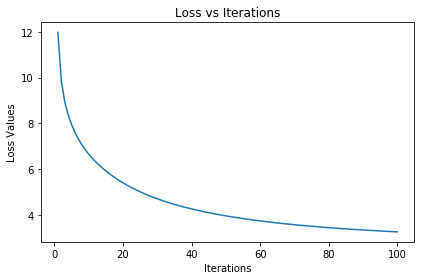

In [102]:
word2vec_model = Word2Vec_IR()
word2vec_model.make_word2vec_data(train_dict)
word2vec_model.train()
word2vec_model.plot_training_curve()

In [103]:
def run_metrics_word2vec(dataset_dict, model = word2vec_model):
    """
    Evaluates the word2vec inspired extended model on ndcg, ndcg alt, and map
    content = 'th' because we built the word2vec embedding only for title and header word of documents
    """
    # TODO: shouldnt have to use the featurizer here, need to improve this API
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        query_words = get_query_words(dataset_dict, query)
        
        scores = []
        for url in url_iter(dataset_dict, query):
            sim_score = model.get_sim_score(dataset_dict, query_words, url)
            scores.append((url, sim_score))
        
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
    
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,}

In [104]:
print("Word2vec extension model performance on dev data with title and header")
run_metrics_word2vec(dev_dict)

Word2vec extension model performance on dev data with title and header


{'NDCG': 0.8906751178720381,
 'Alt_NDCG': 0.8505309883756115,
 'MAP': 0.7915049801282521}

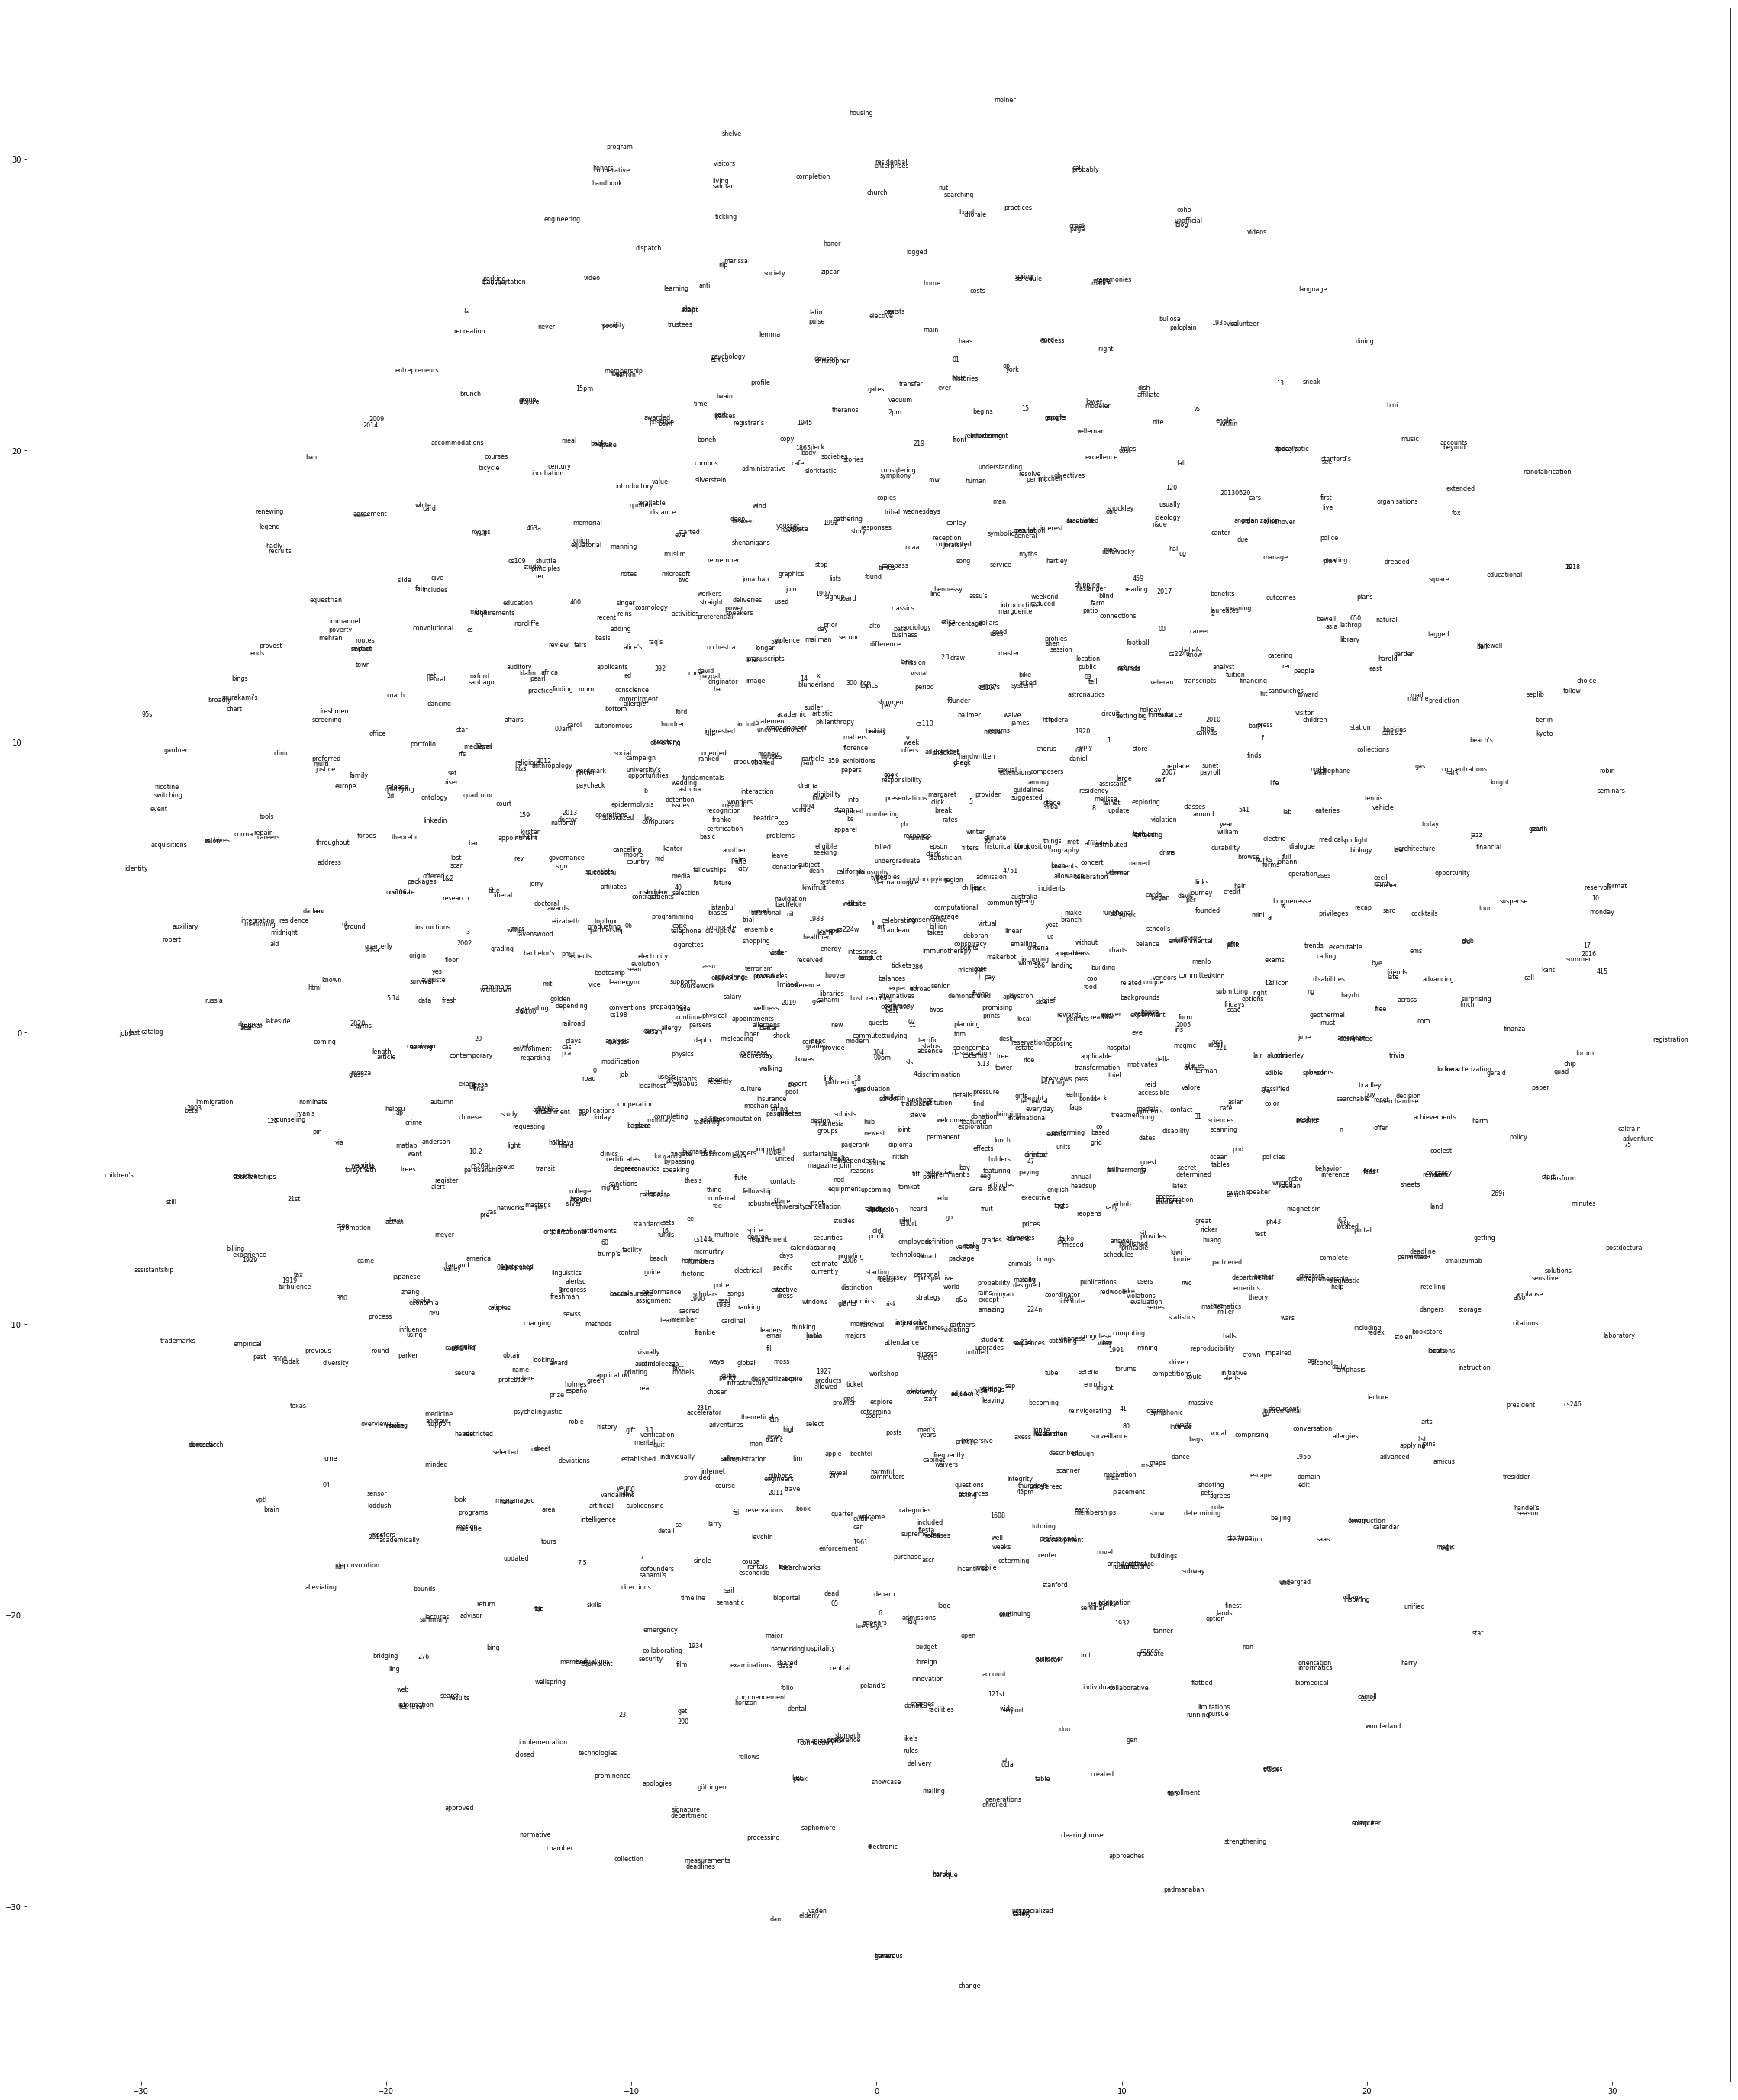

In [113]:
#tsne visualization
import pandas as pd
import vsm
W_df = pd.DataFrame(word2vec_model.W.detach().numpy()).T
W_df.set_index(pd.Series(list(word2vec_model.id_to_word)), inplace=True)
vsm.tsne_viz(W_df)

## Getting Baseline Score

In [106]:
from base_classes.id_map import IdMap
class tf_idf(object):
    def __init__(self, q_weight_scheme=['b', 't', 'n'], doc_weight_scheme=['n', 'n', 'n']):
        '''The default weighing scheme is:
        q_weight_scheme - 
                'b': boolean tf
                't': weighted by idf (smoothed)
                'n': no normalization as the ranking ordering won't be affected
        
        doc_weight_scheme - 
                'n': normal tf
                'n': no idf (would be already contained with query word for sim score calculation)
                'n': none  
        '''
        self.q_weight_scheme = q_weight_scheme
        self.doc_weight_scheme = doc_weight_scheme
        
        try:
            print("Loading idf...\n")
            with open(os.path.join(data_dir, 'docs.dict'), 'rb') as f:
                docs = pkl.load(f)
            self.total_doc_num = len(docs)
            print("Total Number of Docs is", self.total_doc_num)

            with open(os.path.join(data_dir, 'terms.dict'), 'rb') as f:
                terms = pkl.load(f)
            self.total_term_num = len(terms)
            print("Total Number of Terms is", self.total_term_num)

            with open(os.path.join(data_dir, 'BSBI.dict'), 'rb') as f:
                postings_dict, termsID = pkl.load(f)

            self.idf = {}
            for term_ID in postings_dict:
                _, n, _ = postings_dict[term_ID]
                self.idf[terms[term_ID]] = math.log10((self.total_doc_num + 1)/(n + 1))

        except FileNotFoundError:
            print("doc_dict_file / term_dict_file Not Found!")
    
    def get_idf(self, term):
        '''return idf value for a term'''
        return self.idf.get(term.lower(), math.log10((self.total_doc_num+1)))
        
    
    def get_query_vector(self, query_words):
        
        query_vec = {}

        if self.q_weight_scheme[0] == 'b':
            query_vec = Counter(set(query_words))
            
        if self.q_weight_scheme[1] == 't': #idf
            for query_word in query_vec:
                idf_value = self.get_idf(query_word)
                query_vec[query_word] *= idf_value
        
        if self.q_weight_scheme[2] is 'n' or None:
            pass

        return query_vec
        
    
    def get_doc_vector(self, document_words):
        '''document words is a list of word lists in the order [[title], [header]]'''
        doc_vec = {}
        if self.doc_weight_scheme[0] == 'n':
            for word_list in document_words:
                doc_vec.update(Counter(word_list))
        
        if self.doc_weight_scheme[1] == 'n':
            pass
        
        if self.doc_weight_scheme[1] == 'n':
            pass
        
        return doc_vec
            
        
        
    def get_sim_score(self, query_words, document_words):
        """ Get the similarity score between a document and a query. 
        Args:
            query_words : list of query words where each word is a string
            document : list of list of document words where each doc 
            
        Return:
            the raw similarity
        """
        query_vec = self.get_query_vector(query_words)
        doc_vec = self.get_doc_vector(document_words)
        
        similarity_score = 0.
        for q_word in query_vec:
            similarity_score += query_vec[q_word] * doc_vec.get(q_word, 0)
            
        return similarity_score
    
tf_idf_baseline = tf_idf()

Loading idf...

Total Number of Docs is 98998
Total Number of Terms is 347071


In [112]:
def run_metrics_baseline(dataset_dict, baseline_model = tf_idf_baseline, content = 'th'):
    """
    Evaluates the baseline on ndcg, ndcg alt, and map
    content = 'th' - just include title and header
            = 'thb' - run over title, header, and body
    """
    # TODO: shouldnt have to use the featurizer here, need to improve this API
    ndcg_sum = 0.0
    alt_ndcg_sum = 0.0
    precision_sum = 0.0
    n = 0
    
    if content == 'th':
        content_list = ['title', 'header'] 
    elif content == 'thb':
        content_list = ['title', 'header', 'body']
    else:
        raise ValueError('content {} is not valid'.format(content))
    
    for query in query_iter(dataset_dict):
        n += 1
        query_relevance_dict = get_relevance_dict(dataset_dict, query)
        query_words = get_query_words(dataset_dict, query)
        
        scores = []
        for url in url_iter(dataset_dict, query):
            document_words = [get_doc_words(dataset_dict, url, content_type) for content_type in content_list]
            sim_score = baseline_model.get_sim_score(query_words, document_words)
            scores.append((url, sim_score))
        
        scores = sorted(scores, key = lambda x: x[1], reverse=True)
        ranked_doc_list, _ = zip(*scores)
        ranked_doc_list = list(ranked_doc_list)

        ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict)
        alt_ndcg_sum += NDCG(ranked_doc_list, query_relevance_dict, use_alt=True)
        precision_sum += average_precision(ranked_doc_list, query_relevance_dict)
    
    ndcg_sum /= n
    alt_ndcg_sum  /= n
    precision_sum /= n
    return {'NDCG': ndcg_sum,
            'Alt_NDCG': alt_ndcg_sum,
            'MAP': precision_sum,}

In [113]:
print("Baseline performance on training data with title and header only")
run_metrics_baseline(train_dict, content = 'th')

Baseline performance on training data with title and header only


{'NDCG': 0.859428187699434,
 'Alt_NDCG': 0.8090768420250245,
 'MAP': 0.7657398318695526}

In [114]:
print("Baseline performance on dev data with title and header only")
run_metrics_baseline(dev_dict, content = 'th')

Baseline performance on dev data with title and header only


{'NDCG': 0.8602470267115788,
 'Alt_NDCG': 0.8057228287185719,
 'MAP': 0.7677681543047327}

In [115]:
print("Baseline performance on training data with title, header, and body")
run_metrics_baseline(train_dict, content='thb')

Baseline performance on training data with title, header, and body


{'NDCG': 0.8511618664512215,
 'Alt_NDCG': 0.7948887145778446,
 'MAP': 0.7653206132994661}

In [116]:
print("Baseline performance on dev data with title, header, and body")
run_metrics_baseline(dev_dict, content='thb')

Baseline performance on dev data with title, header, and body


{'NDCG': 0.8476474846950123,
 'Alt_NDCG': 0.7853309860078931,
 'MAP': 0.7671287533830737}

## Some Glove checkup

In [ ]:
qwords_not_in_glove = {}
for query in query_iter(train_dict):
    query_words = get_query_words(train_dict, query)
    for qw in query_words:
        if qw not in glove_lookup:
            qwords_not_in_glove[qw] = qwords_not_in_glove.get(qw, 0) + 1
print(qwords_not_in_glove)

In [50]:
GLOVE_CS276_HOME = os.path.join(os.path.join(base_dir_name, os.path.join('data', 'glove.6B')), 'cs276_glove.6B')
glove_cs276_lookup = utils.glove2dict(os.path.join(GLOVE_CS276_HOME, 'glove.6B.100d.txt'))

In [ ]:
qwords_not_in_cs276_glove = {}
for query in query_iter(train_dict):
    query_words = get_query_words(train_dict, query)
    for qw in query_words:
        if qw not in glove_cs276_lookup:
            qwords_not_in_cs276_glove[qw] = qwords_not_in_cs276_glove.get(qw, 0) + 1
print(qwords_not_in_cs276_glove)

In [63]:
near_words = ['stanford', 'university', 'location', 'course', 'assignment', 'cs', \
               'student', 'professor', 'recreational', 'gym']
not_there = []

for n_w in near_words:
    if n_w not in glove_lookup:
        not_there.append(n_w)
        
if len(not_there) == 0:
    print("All words present")
else:
    print(not_there)

All words present


In [ ]:
other_words_embeddings = {} #word embeddings for words not present in the vocab

near_words = ['stanford', 'university', 'location', 'course', 'assignment', 'cs', \
               'student', 'professor', 'recreational', 'gym']

#change function name to make_glove_embedding if you want to use this and fit to other api functions
def make_glove_embedding_random(words, combine_func=None, glove_dim = 100):
    '''This function tries to handle the OOV words by taking a random weighing of the embeddings from the
    near_words_words. This handling failed to give improved results over the original make_glove_embedding and makes
    the approach very domain specific.'''
    
    if len(words) == 0:
        return np.zeros(glove_dim)
    
    for word in words:
        assert isinstance(word, str), (type(word), word)

    global other_words_embeddings
    
    embedding_list = []
    for word in words:
        if word in glove_lookup:
            embedding_list.append(glove_lookup[word])
        elif word in other_words_embeddings:
            embedding_list.append(other_words_embeddings[word])
        else:
            random_numbers = np.random.randint(5, size = 10)
            assert np.sum(random_numbers) > 0, "Random number summing to zero"
            random_numbers = random_numbers/np.sum(random_numbers)
            
            embedding = np.zeros(glove_dim)
            for i in range(len(near_words)):
                embedding += random_numbers[i] * np.array(glove_lookup[near_words[i]])
            other_words_embeddings[word] = list(embedding)
            embedding_list.append(other_words_embeddings[word])
            
    assert len(embedding_list) == len(words), "Random embeddings not created"
    
    embedding_list = np.array(embedding_list)
    if combine_func:
        feats = combine_func(embedding_list)
    else: # take the elemnetwise mean by default
        feats = np.mean(embedding_list, axis=0) 
    
    return feats

make_glove_embedding(['aoerc'], combine_func=None, glove_dim = 100)
make_glove_embedding(['abjbh'], combine_func=None, glove_dim = 100)

In [89]:
print("Title on train with embedded OOV")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='title')

Title on train with embedded OOV


{'NDCG': 0.8644623028586048,
 'Alt_NDCG': 0.8152507288574898,
 'MAP': 0.7760472346853018}

In [91]:
print("Title on dev with embedded OOV")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='title')

Title on dev with embedded OOV


{'NDCG': 0.8588523197194919,
 'Alt_NDCG': 0.8080965801311629,
 'MAP': 0.7638800121303003}

In [92]:
print("Header on train with embedded OOV")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='header')

Header on train with embedded OOV


{'NDCG': 0.8566425658842325,
 'Alt_NDCG': 0.8034638293190356,
 'MAP': 0.7669517475808014}

In [93]:
print("Header on dev with embedded OOV")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='header')

Header on dev with embedded OOV


{'NDCG': 0.8565573820349158,
 'Alt_NDCG': 0.8011692169873779,
 'MAP': 0.7684341702630876}

In [94]:
print("2th on train with embedded OOV")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='2th')

2th on train with embedded OOV


{'NDCG': 0.8675480398731951,
 'Alt_NDCG': 0.818663948699515,
 'MAP': 0.7777938315587334}

In [95]:
print("2th on dev with embedded OOV")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='2th')

2th on dev with embedded OOV


{'NDCG': 0.868774301574093,
 'Alt_NDCG': 0.8188404574703219,
 'MAP': 0.7784159824323995}

In [96]:
print("body on train with embedded OOV")
run_metrics(train_dict, scoring_func=cosine_similarity, content_type='body')

body on train with embedded OOV


{'NDCG': 0.8522017338427332,
 'Alt_NDCG': 0.7944443819485472,
 'MAP': 0.7679846326974642}

In [97]:
print("body on dev with embedded OOV")
run_metrics(dev_dict, scoring_func=cosine_similarity, content_type='body')

body on dev with embedded OOV


{'NDCG': 0.864038395716416,
 'Alt_NDCG': 0.8037427257593366,
 'MAP': 0.791294673335284}